In [1]:
### E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 
### Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
### Doesn't look like a very big improvement to me.

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

In [6]:
t = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    trigram = (ch1, ch2, ch3)
    t[trigram] = t.get(trigram, 0) + 1

In [7]:
sorted(t.items(), key = lambda kv: -kv[1])

[(('a', 'h', '<E>'), 1714),
 (('n', 'a', '<E>'), 1673),
 (('a', 'n', '<E>'), 1509),
 (('o', 'n', '<E>'), 1503),
 (('<S>', 'm', 'a'), 1453),
 (('<S>', 'j', 'a'), 1255),
 (('<S>', 'k', 'a'), 1254),
 (('e', 'n', '<E>'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '<E>'), 953),
 (('a', 'r', 'i'), 950),
 (('i', 'a', '<E>'), 903),
 (('i', 'e', '<E>'), 858),
 (('a', 'n', 'n'), 825),
 (('e', 'l', 'l'), 822),
 (('a', 'n', 'a'), 804),
 (('i', 'a', 'n'), 790),
 (('m', 'a', 'r'), 776),
 (('i', 'n', '<E>'), 766),
 (('e', 'l', '<E>'), 727),
 (('y', 'a', '<E>'), 716),
 (('a', 'n', 'i'), 703),
 (('<S>', 'd', 'a'), 700),
 (('l', 'a', '<E>'), 684),
 (('e', 'r', '<E>'), 683),
 (('i', 'y', 'a'), 669),
 (('l', 'a', 'n'), 647),
 (('<S>', 'b', 'r'), 646),
 (('n', 'n', 'a'), 633),
 (('<S>', 'a', 'l'), 632),
 (('<S>', 'c', 'a'), 628),
 (('r', 'a', '<E>'), 627),
 (('n', 'i', '<E>'), 625),
 (('<S>', 'a', 'n'), 623),
 (('n', 'n', '<E>'), 619),
 (('n', 'e', '<E>'), 607),
 (('e', 'e', '<E>'), 605),
 (('e', 'y', '<

In [8]:
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# lets check if we have same shuffle in both notebooks using our own local random object,
# with the same seed - it works
r = random.Random(2147483647)
r.shuffle(words)
words[:5]

['khole', 'harbour', 'devon', 'baine', 'erisha']

In [10]:
# Split into train/dev/test set
p80 = int(len(words) * 0.8)
p90 = int(len(words) * 0.9)
print(f'{p80=}, {p90=}')
train = words[:p80]
dev = words[p80:p90]
test = words[p90:]
print(f'train %: {len(train)/len(words)*100}, dev %: {len(dev)/len(words)*100}, test %: {len(test)/len(words)*100}')

p80=25626, p90=28829
train %: 79.99875128773452, dev %: 9.999063465800893, test %: 10.002185246464583


In [11]:
print(train[:5])
print(dev[:5])
print(test[:5])

['khole', 'harbour', 'devon', 'baine', 'erisha']
['shterna', 'tyanna', 'sarra', 'malachy', 'zenaya']
['phoenyx', 'christionna', 'bastien', 'niloufar', 'masa']


In [12]:
# pair -> char
# m = number of pairs; n = number of chars: same as in bigrams
# so our matrix of counts/probs will be m x n

In [13]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [14]:
# We actually need all possible pairs of our chars, as sampling can come up
# with a pair not seen it the actual data. 27*27

In [15]:
# same as with chars, but we need all pairs
pairs = []
for i in range(27):
  for j in range(27):
    pairs.append(itos[i] + itos[j])
pairs.sort()
# need to populate pair to ix and ix to pair dicts
pairtoi = {p:i for i,p in enumerate(pairs)}
itopair = {i:p for p,i in pairtoi.items()}

In [16]:
len(pairtoi), len(stoi)

(729, 27)

In [17]:
# Matrix of counts how often a pair followed by a char
# we build it only from train dataset
N = torch.zeros((729, 27), dtype=torch.int32)
for w in train:
  # as we now using pairs, we start with ..
  # didn't come up with better solution
  chs = ['.', '.'] + list(w) + ['.']
  # we can use indecies, but for simplicity just 3 iters
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    N[ix1, ix2] += 1
    

In [18]:
N[0]

tensor([   0, 3522, 1040, 1238, 1351, 1248,  349,  534,  713,  477, 1935, 2305,
        1272, 2026,  941,  310,  412,   75, 1304, 1634, 1036,   68,  296,  244,
         110,  443,  743], dtype=torch.int32)

In [19]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1374, 0.0406, 0.0483, 0.0527, 0.0487, 0.0136, 0.0208, 0.0278,
        0.0186, 0.0755, 0.0899, 0.0496, 0.0791, 0.0367, 0.0121, 0.0161, 0.0029,
        0.0509, 0.0638, 0.0404, 0.0027, 0.0116, 0.0095, 0.0043, 0.0173, 0.0290])

In [20]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [21]:
P = (N+1).float() # N+1 is smoothing, so to not have inf loss on zero prob
P /= P.sum(1, keepdims=True)

In [22]:
P[1].sum()

tensor(1.)

In [23]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
  
  out = ['.']  # prepopulate with first .
  i = 0 # start sampling from what char follows '..'
  while True:
    p = P[i]
    j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[j])
    if j == 0: # we've sampled end of word
      break
    # update index i
    pair = ''.join(out[-2:])  # last 2 chars
    i = pairtoi[pair]

  print(''.join(out[1:]))

junide.
janasid.
prelay.
adin.
kairritoper.
sathen.
sameia.
yanileniassibduinrwin.
lessiyanayla.
te.


In [24]:
# Trying different seeds, it looks like more generated words became name-like. Tend to generate very long words as well.

In [25]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [26]:
# evaluate on train
log_likelihood = 0.0
n = 0

for w in train:
# for w in ["alexey"]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print('evaluate on train')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

evaluate on train
log_likelihood=tensor(-404414.3438)
nll=tensor(404414.3438)
2.2154107093811035


In [27]:
# evaluate on dev
log_likelihood = 0.0
n = 0

for w in dev:
# for w in ["alexey"]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print('evaluate on dev')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

evaluate on dev
log_likelihood=tensor(-51308.7266)
nll=tensor(51308.7266)
2.246441602706909


In [28]:
# evaluate on test
log_likelihood = 0.0
n = 0

for w in test:
# for w in ["alexey"]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print('evaluate on test')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

evaluate on test
log_likelihood=tensor(-50781.2344)
nll=tensor(50781.2344)
2.23116135597229


In [29]:
# Increasing context to have a probability of char following a pair improves loss.
# Also, the loss is slightly worse on dev and test data, train data counts do not
# ideally correspond to dev and test data statistics

In [149]:
# create the training set of trigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. . k
. k h
k h o
h o l
o l e
l e .


In [150]:
xs

tensor([  0,  11, 305, 231, 417, 329])

In [151]:
ys

tensor([11,  8, 15, 12,  5,  0])

In [152]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=729).float()
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [153]:
xenc.shape

torch.Size([6, 729])

In [154]:
xenc.dtype

torch.float32

In [155]:
W = torch.randn((729, 27))
xenc @ W

tensor([[ 0.3330,  0.9040,  0.7693,  0.8841, -0.8210,  0.4556,  0.2812,  1.6566,
         -0.0462,  1.0639,  1.0169,  0.8743, -0.2645, -0.0313,  1.4194, -0.8452,
         -0.1355, -0.5264, -1.0420, -0.2459,  0.5305, -0.1876, -0.7527,  0.4978,
          1.2228,  1.4424, -0.7958],
        [-0.4170, -0.4721, -0.1154, -1.9393,  0.9747,  0.6635, -1.2128,  0.9112,
          0.4879, -2.2577, -0.1443,  1.4556,  0.8156, -0.6411,  0.9174,  0.9576,
          0.2845, -1.1637, -1.2280,  0.0589, -2.1340,  1.5269,  0.9811,  0.3087,
          0.6719, -1.8730,  0.0574],
        [ 1.3883,  1.1179, -0.8733,  0.1592, -0.6423,  0.1696, -0.1293,  0.8133,
         -0.0437,  0.4073, -0.2438, -1.2735,  0.6785,  0.5482, -1.2784, -0.6018,
         -1.7337, -1.1548,  1.5994, -0.0615,  2.3889, -1.7634,  1.2109, -0.2141,
         -1.4938,  1.0882,  1.3493],
        [-0.0337, -0.5630, -2.2842,  1.1928,  1.1905, -0.7333,  1.1402, -0.4271,
         -1.7268,  0.5635,  1.0991,  0.3150, -1.1803,  0.0669, -0.4096,  0.8062

In [156]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0293, 0.0518, 0.0453, 0.0508, 0.0092, 0.0331, 0.0278, 0.1100, 0.0200,
         0.0608, 0.0580, 0.0503, 0.0161, 0.0203, 0.0867, 0.0090, 0.0183, 0.0124,
         0.0074, 0.0164, 0.0357, 0.0174, 0.0099, 0.0345, 0.0713, 0.0888, 0.0095],
        [0.0167, 0.0158, 0.0226, 0.0037, 0.0673, 0.0493, 0.0075, 0.0631, 0.0413,
         0.0027, 0.0220, 0.1088, 0.0574, 0.0134, 0.0635, 0.0661, 0.0337, 0.0079,
         0.0074, 0.0269, 0.0030, 0.1169, 0.0677, 0.0346, 0.0497, 0.0039, 0.0269],
        [0.0798, 0.0609, 0.0083, 0.0233, 0.0105, 0.0236, 0.0175, 0.0449, 0.0191,
         0.0299, 0.0156, 0.0056, 0.0392, 0.0345, 0.0055, 0.0109, 0.0035, 0.0063,
         0.0986, 0.0187, 0.2171, 0.0034, 0.0668, 0.0161, 0.0045, 0.0591, 0.0768],
        [0.0209, 0.0123, 0.0022, 0.0714, 0.0712, 0.0104, 0.0677, 0.0141, 0.0039,
         0.0381, 0.0650, 0.0297, 0.0067, 0.0232, 0.0144, 0.0485, 0.0642, 0.0172,
         0.0388, 0.0105, 0.0090, 0.0099, 0.0710, 0.1338, 0.0064, 0.0210, 0.1185],
        [0.0281, 0.0212,

In [157]:
# with pytorch we can index into tensor using list-like object
(W[xs] == logits).all()

tensor(True)

In [158]:
probs[0]

tensor([0.0293, 0.0518, 0.0453, 0.0508, 0.0092, 0.0331, 0.0278, 0.1100, 0.0200,
        0.0608, 0.0580, 0.0503, 0.0161, 0.0203, 0.0867, 0.0090, 0.0183, 0.0124,
        0.0074, 0.0164, 0.0357, 0.0174, 0.0099, 0.0345, 0.0713, 0.0888, 0.0095])

In [159]:
probs[0].shape

torch.Size([27])

In [160]:
probs[0].sum()

tensor(1.)

In [161]:
# SUMMARY ------------------------------>>>>

In [162]:
xs

tensor([  0,  11, 305, 231, 417, 329])

In [163]:
ys

tensor([11,  8, 15, 12,  5,  0])

In [164]:
# randomly initialize 27 neurons' weights. each neuron receives 729 inputs (all possible pairs)
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((729, 27), generator=g)

In [165]:
xenc = F.one_hot(xs, num_classes=729).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [166]:
# no wasteful one-hot encoding
logits = W[xs] # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [167]:

nlls = torch.zeros(6)
for i in range(6):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itopair[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: ..k (indexes 0,11)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 11
probability assigned by the net to the the correct character: 0.027797512710094452
log likelihood: -3.58280873298645
negative log likelihood: 3.58280873298645
--------
bigram example 2: .kh (indexes 11,8)
input to the neural net: 11
output probabilities from the neural net: tensor([0.0065, 0.0446, 0.0052, 0.0091, 0.0787, 0.0122, 0.0621, 0.0676, 0.0543,
        0.0146, 0.0066, 0.0622, 0.1245, 0.0203, 0.0145, 0.0502, 0.0342, 0.0201,
        0.0365, 0.0386, 0.0637, 0.0165, 0.0617, 0.0343, 0.0405, 0.0025, 0.0182])
label (actual next character): 8
probability assigned by the net to the the correct character:

In [168]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [169]:
xs

tensor([  0,  11, 305, 231, 417, 329])

In [170]:
ys

tensor([11,  8, 15, 12,  5,  0])

In [173]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((729, 27), generator=g, requires_grad=True)

In [174]:
# forward pass
xenc = F.one_hot(xs, num_classes=729).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(6), ys].log().mean()

In [175]:
print(loss.item())

3.076528310775757


In [176]:
# forward pass with ex.4 and ex.5 updates
logits = W[xs]
loss = F.cross_entropy(logits, ys)

In [177]:
print(loss.item())

3.076528310775757


In [112]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [113]:
W.data += -0.1 * W.grad

In [56]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [114]:
# create train dataset
xs, ys = [], []
for w in train:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of train examples: ', num)

# create dev dataset
xdevs, ydevs = [], []
for w in dev:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    xdevs.append(ix1)
    ydevs.append(ix2)
xdevs = torch.tensor(xdevs)
ydevs = torch.tensor(ydevs)
num_dev = xdevs.nelement()
print('number of dev examples: ', num_dev)

number of train examples:  182546
number of dev examples:  22840


In [115]:
def plot_train_dev_loss(train_losses, dev_losses, reg_strength):
  plt.plot(train_losses, label='train')
  plt.plot(dev_losses, label='dev')
  plt.xlabel('Epoch')
  plt.ylabel('NLL Loss')
  plt.title(f'Reg Strength: {reg_strength}')
  plt.legend()
  plt.show()

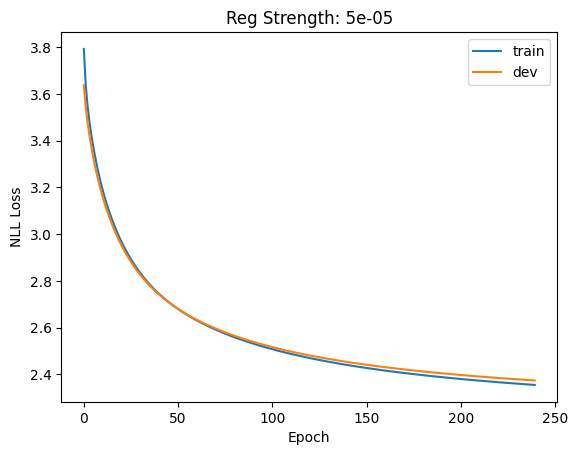

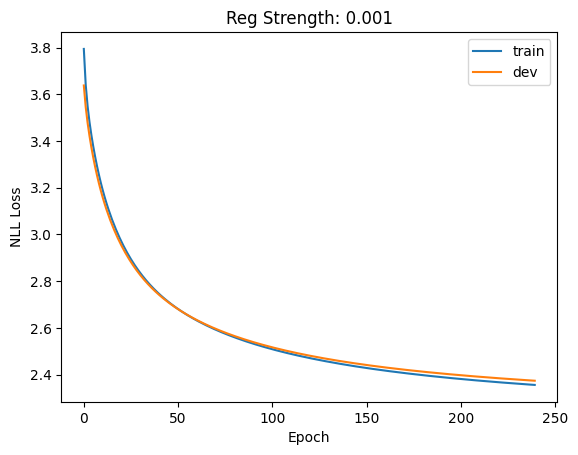

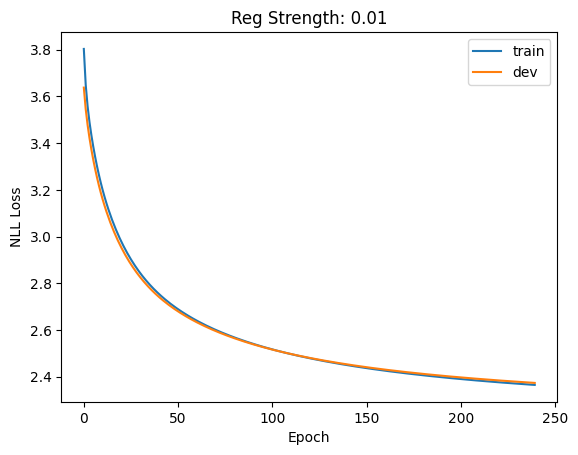

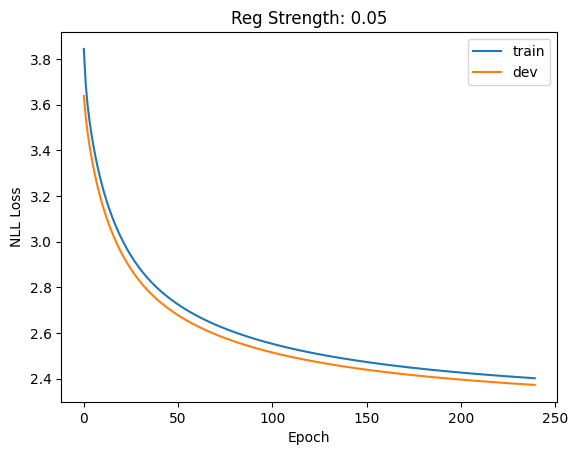

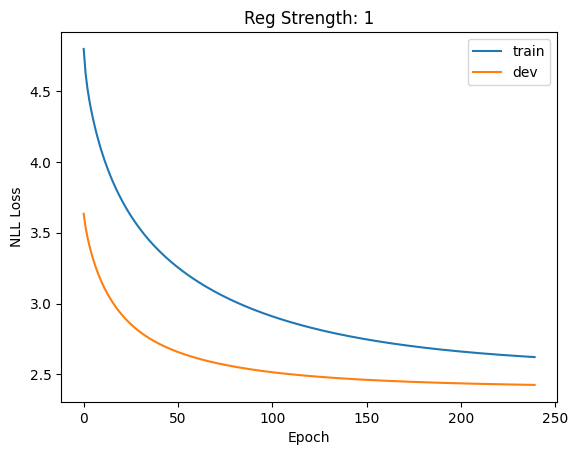

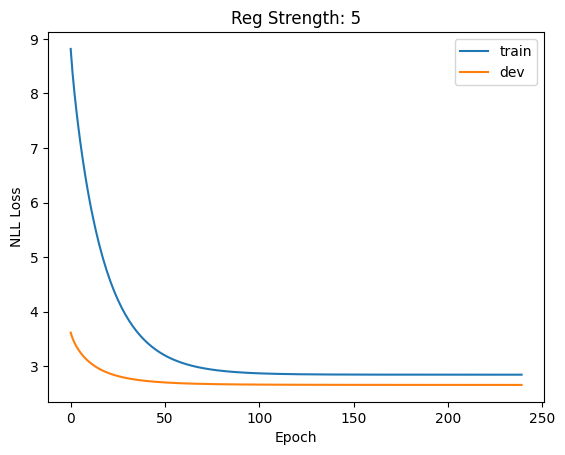

In [116]:
# E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - 
# i.e. try many possibilities and see which one works best based on the dev set loss. 
# What patterns can you see in the train and dev set loss as you tune this strength? 
# Take the best setting of the smoothing and evaluate on the test set once and at the end. 
# How good of a loss do you achieve?

# First intuition. The loss has two components. 1. To initiativize learning weights
# to predict probabilities of a character following a pair as it was seen in training data.
# 2. To penalize for large weight^2 / to push weights closer to zero everywhere. They are competing
# forces. To predict better we need some weights to be larger and some to be smaller. For second 
# loss component ideal will be all W to be zero, but then predictions will be just uniform.

# When evaluating on dev set, we can't clearly compare only NLL components of the overall loss,
# but we actually mostly care about it. We can remove regularization component from the dev loss.
# This way we can see, how different regularization strengths during training influence our NLL dev loss.

# E04. We change code here to remove one-hot encoding and simply index into weights.
# Removing one-hot encoding and eventually matrix multiplication speed-up the process significantly!

# E05. Change our manual softmax -> nll into cross_entropy. CE ~ LogSoftMax followed by NLL
# Why LogSoftMax? gradient of log(p(x)) is usually much better scaled than gradient of p(x)
# which implies a better fit for gradient optimization.

experiments = {}

# every iteration is one experiment with some regularization strength
for reg_strength in [0.00005, 0.001, 0.01, 0.05, 1, 5]:
  # initialize the 'network' for every experiment
  g = torch.Generator().manual_seed(2147483647)
  W = torch.randn((729, 27), generator=g, requires_grad=True)
  train_losses = []
  dev_losses = []
  
  for k in range(240):
    
    # forward pass
    logits = W[xs] # predict log-counts
    loss = F.cross_entropy(logits, ys) + reg_strength*(W**2).mean()
    train_losses.append(loss.item())
    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    # update
    W.data += -50 * W.grad
    
    # forward pass to evaluate loss
    with torch.no_grad():
      logits = W[xdevs] # predict log-counts
      loss = F.cross_entropy(logits, ydevs) # only want to see NLL part
      dev_losses.append(loss.item())

  # plot after finishing experiment
  plot_train_dev_loss(train_losses, dev_losses, reg_strength)
  # save experiment data
  experiments[str(reg_strength)] = [train_losses, dev_losses]

In [117]:
for k, v in experiments.items():
  print(f'{k}, final train loss: {v[0][-1]}, final dev loss: {v[1][-1]}')

5e-05, final train loss: 2.354459762573242, final dev loss: 2.3734776973724365
0.001, final train loss: 2.3554582595825195, final dev loss: 2.3734641075134277
0.01, final train loss: 2.3647420406341553, final dev loss: 2.373347759246826
0.05, final train loss: 2.4023079872131348, final dev loss: 2.3730719089508057
1, final train loss: 2.621879816055298, final dev loss: 2.4252352714538574
5, final train loss: 2.845529079437256, final dev loss: 2.657803535461426


evaluate loss on test dataset
number of test examples:  22760


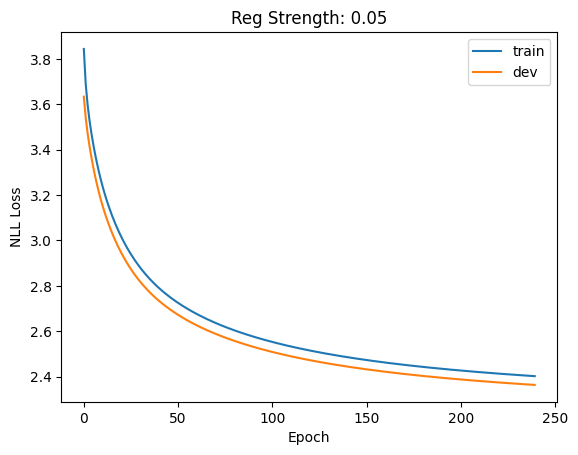

In [119]:
# create the dataset from test data
print('evaluate loss on test dataset')
xtests, ytests = [], []
for w in test:
  chs = ['.', '.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = pairtoi[ch1+ch2]
    ix2 = stoi[ch3]
    xtests.append(ix1)
    ytests.append(ix2)
xtests = torch.tensor(xtests)
ytests = torch.tensor(ytests)
num_test = xtests.nelement()
print('number of test examples: ', num_test)

# we remove one-hot encoding (ex. 4)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((729, 27), generator=g, requires_grad=True)
train_losses = []
dev_losses = []

# train model with the best regularization settings
for k in range(240):
  
  # forward pass
  logits = W[xs] # predict log-counts
  # counts = logits.exp() # counts, equivalent to N
  # probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  # loss = -probs[torch.arange(num), ys].log().mean() + 0.05*(W**2).mean() # best on dev set
  loss = F.cross_entropy(logits, ys) + 0.05*(W**2).mean()  # E05 change
  train_losses.append(loss.item())
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  # update
  W.data += -50 * W.grad
  
  # forward pass to evaluate loss
  with torch.no_grad():
    logits = W[xtests] # predict log-counts
    # counts = logits.exp() # counts, equivalent to N
    # probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # loss = -probs[torch.arange(num_test), ytests].log().mean() # only want to see NLL part
    loss = F.cross_entropy(logits, ytests)  # E05 change
    dev_losses.append(loss.item())

# plot after finishing experiment
plot_train_dev_loss(train_losses, dev_losses, 0.05)

In [120]:
train_losses[-1], dev_losses[-1]

(2.4023079872131348, 2.363720655441284)

In [121]:
# The loss for nn trigram model is only a little better than for bigram. Quality of generation is not much better.
# NN also can't achieve 2.21 trigram statistical model result. Counting model has exact answers,
# it counted trigrams. On the other hand with nn we are trying to learn these counts from data using gradient
# descent.

In [122]:
# Evaluating on dev and test gives just a bit worse loss

In [124]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
  
  out = ['.']
  i = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    logits = W[[i]] # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[j])
    if j == 0:
      break
    # update index i
    pair = ''.join(out[-2:])  # last 2 chars
    i = pairtoi[pair]
  print(''.join(out[1:]))

juwjde.
janaqah.
prefarie.
na.
kairritonian.


In [125]:
W[0]

tensor([-3.2877,  2.1189,  0.8987,  1.0730,  1.1604,  1.0811, -0.1923,  0.2324,
         0.5213,  0.1196,  1.5198,  1.6948,  1.1001,  1.5658,  0.7987, -0.3104,
        -0.0267, -1.7135,  1.1250,  1.3507,  0.8949, -1.8020, -0.3565, -0.5489,
        -1.3379,  0.0458,  0.5625], grad_fn=<SelectBackward0>)

In [126]:
W[1]

tensor([-2.0264,  0.7516,  0.5518, -1.0765,  1.2998, -0.6347, -1.2437, -1.5914,
        -0.1468,  0.3958, -1.1885, -0.3130,  1.8059,  1.2862,  1.8281, -1.7363,
        -1.4305, -1.9497,  1.5807,  0.6208, -0.3000,  0.3553,  0.8193, -1.7163,
        -1.1441,  0.5519,  0.3800], grad_fn=<SelectBackward0>)